## ISCX 2016: Binary Analiz

### Kurulumlar

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq 

In [ ]:
!sudo add-apt-repository ppa:webupd8team/java
!sudo apt-get update
!sudo apt-get install oracle-java8-installer

 The Oracle JDK License has changed for releases starting April 16, 2019.

The new Oracle Technology Network License Agreement for Oracle Java SE is substantially different from prior Oracle JDK licenses. The new license permits certain uses, such as personal use and development use, at no cost -- but other uses authorized under prior Oracle JDK licenses may no longer be available. Please review the terms carefully before downloading and using this product. An FAQ is available here: https://www.oracle.com/technetwork/java/javase/overview/oracle-jdk-faqs.html

Oracle Java downloads now require logging in to an Oracle account to download Java updates, like the latest Oracle Java 8u211 / Java SE 8u212. Because of this I cannot update the PPA with the latest Java (and the old links were broken by Oracle).

For this reason, THIS PPA IS DISCONTINUED.

UPDATE:

For Oracle Java 17, see a different PPA -> https://www.linuxuprising.com/2021/09/how-to-install-oracle-java-17-lts-on.html

Old descr

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ISCX2016_vpn_nonvpn_analiz/

Mounted at /content/drive
/content/drive/My Drive/ISCX2016_vpn_nonvpn_analiz


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
      .master("local") \
      .appName("iscx2016_project") \
      .config("spark.executor.memory", "12gb") \
      .getOrCreate()
    
sc = spark.sparkContext

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

### Preprocessing

In [ ]:
dataset = pd.read_csv("dataset_V2.csv")

In [ ]:
dataset

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,44917,443,6,119836611,45,45,3100.0,6118.0,234,0,...,0,3.995741e+06,4.393032e+06,14100000.0,201504.0,7556492.7,2.991504e+06,13600000.0,5092871.0,VPN - Chat
1,48410,443,6,119999002,4,5,24.0,6.0,6,6,...,0,1.734618e+05,3.501468e+03,178627.0,170890.0,29800000.0,3.109753e+03,29800000.0,29800000.0,VPN - Chat
2,34342,443,6,119999037,4,5,24.0,6.0,6,6,...,0,1.771350e+05,4.698987e+03,184066.0,173876.0,29800000.0,4.218229e+03,29800000.0,29800000.0,VPN - Chat
3,44917,443,6,118918424,40,38,2978.0,4816.0,266,0,...,0,1.911945e+06,2.264153e+06,5313599.0,69.0,12300000.0,1.040000e+07,33000000.0,5099408.0,VPN - Chat
4,48410,443,6,119829597,4,4,24.0,0.0,6,6,...,0,1.729873e+05,1.093698e+03,174193.0,172059.0,29800000.0,2.395638e+03,29800000.0,29800000.0,VPN - Chat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45532,56962,5355,17,418993,1,1,22.0,22.0,22,22,...,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Chat
45533,58618,5355,17,411298,1,1,22.0,22.0,22,22,...,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Chat
45534,50261,5355,17,411211,1,1,22.0,22.0,22,22,...,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Chat
45535,137,137,17,35204260,11,1,550.0,50.0,50,50,...,0,1.514065e+06,0.000000e+00,1514065.0,1514065.0,31400000.0,0.000000e+00,31400000.0,31400000.0,Chat


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45537 entries, 0 to 45536
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Src Port           45537 non-null  int64  
 1   Dst Port           45537 non-null  int64  
 2   Protocol           45537 non-null  int64  
 3   Flow Duration      45537 non-null  int64  
 4   Tot Fwd Pkts       45537 non-null  int64  
 5   Tot Bwd Pkts       45537 non-null  int64  
 6   TotLen Fwd Pkts    45537 non-null  float64
 7   TotLen Bwd Pkts    45537 non-null  float64
 8   Fwd Pkt Len Max    45537 non-null  int64  
 9   Fwd Pkt Len Min    45537 non-null  int64  
 10  Fwd Pkt Len Mean   45537 non-null  float64
 11  Fwd Pkt Len Std    45537 non-null  float64
 12  Bwd Pkt Len Max    45537 non-null  int64  
 13  Bwd Pkt Len Min    45537 non-null  int64  
 14  Bwd Pkt Len Mean   45537 non-null  float64
 15  Bwd Pkt Len Std    45537 non-null  float64
 16  Flow Byts/s        455

In [ ]:
dataset.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,45537.000000,45537.000000,45537.000000,4.553700e+04,45537.000000,45537.000000,4.553700e+04,4.553700e+04,45537.000000,45537.000000,...,45537.000000,45537.0,4.553700e+04,4.553700e+04,4.553700e+04,4.553700e+04,4.553700e+04,4.553700e+04,4.553700e+04,4.553700e+04
mean,38298.110064,7580.231833,14.224674,1.567862e+07,155.021850,188.226519,4.617080e+04,1.788046e+05,101.074577,13.455102,...,75.264862,0.0,3.065390e+05,1.856976e+05,5.498512e+05,1.668609e+05,5.672726e+06,6.921344e+05,6.297556e+06,5.076941e+06
std,20599.092074,15007.414500,4.932967,3.509886e+07,3137.057016,5547.907712,1.402335e+06,7.311006e+06,844.912861,38.086296,...,1164.603006,0.0,2.464251e+06,1.622656e+06,3.886524e+06,2.017148e+06,1.572101e+07,4.099770e+06,1.701367e+07,1.506030e+07
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,19878.000000,53.000000,17.000000,7.430000e+02,0.000000,1.000000,0.000000e+00,2.200000e+01,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43597.000000,443.000000,17.000000,1.336590e+05,1.000000,2.000000,0.000000e+00,1.750000e+02,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,55672.000000,5355.000000,17.000000,4.217850e+05,1.000000,2.000000,2.200000e+01,3.780000e+02,22.000000,22.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65534.000000,65514.000000,17.000000,1.200000e+08,238160.000000,470863.000000,1.320000e+08,6.700000e+08,64240.000000,1338.000000,...,62415.000000,0.0,1.110000e+08,5.660000e+07,1.110000e+08,1.110000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [ ]:
dataset.Label.value_counts()

VPN - VOIP             13796
VOIP                    7101
Chat                    6596
Email                   5071
VPN - Chat              4540
Streaming               3335
VPN - File Transfer     1794
File Transfer           1598
VPN - Streaming         1137
VPN - Email              569
Name: Label, dtype: int64

In [ ]:
dataset["Label"].to_numpy()
traffic_type=[]
for i in dataset["Label"]:
    if "VPN" in i:
        traffic_type.append("VPN")
    else:
        traffic_type.append("NON-VPN")          
dataset["Traffic"]=traffic_type

In [ ]:
dataset.Traffic.value_counts()

NON-VPN    23701
VPN        21836
Name: Traffic, dtype: int64

Text(0.5, 1.0, 'Numbers of Traffic Classification ')

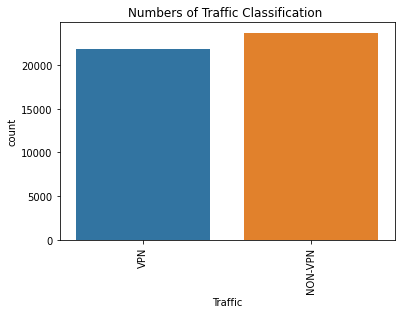

In [ ]:
sbn.countplot(x="Traffic", data = dataset)
plt.xticks(rotation = 'vertical')
plt.title(label="Numbers of Traffic Classification ")

In [ ]:
dataset= dataset.drop(columns= ['Label'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

dataset["Traffic"]= LabelEncoder().fit_transform(dataset["Traffic"])

In [ ]:
dataset.Traffic.value_counts()

0    23701
1    21836
Name: Traffic, dtype: int64

In [ ]:
data = dataset.iloc[:,:-1]

In [ ]:
zero= []
data.to_numpy()
for i in data:
  if data[i].var(axis=0) == 0.0:
     zero.append(i)
print(zero)

['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Init Fwd Win Byts', 'Fwd Seg Size Min']


In [ ]:
dataset= dataset.drop(columns= ['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 
                                'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 
                                'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 
                                'Init Fwd Win Byts', 'Fwd Seg Size Min'])


In [ ]:
dataset = spark.createDataFrame(dataset)

In [ ]:
from pyspark.sql import functions as F

for col in dataset.columns:
  dataset = dataset.withColumn(
    col,
    F.col(col).cast("long")
  )

In [ ]:
dataset.drop("Traffic").toPandas().columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       '

In [ ]:
from pyspark.ml.feature import VectorAssembler

assemblerInput = ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']

assembler = VectorAssembler(inputCols= assemblerInput,  outputCol='vectorized_features')

vectorized_dataset = assembler.transform(dataset)

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol='vectorized_features', outputCol="scaledFeatures")
scalerModel = scaler.fit(vectorized_dataset)
scaled_Data = scalerModel.transform(vectorized_dataset)

In [ ]:
dataset=scaled_Data.select("scaledFeatures", 'Traffic')

In [ ]:
train_data,test_data = dataset.randomSplit([0.8,0.2], seed=42)

### 1: Random Forest

In [ ]:
# ----------------RANDOM FOREST ALGORİTMASI------------------

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Traffic', featuresCol='scaledFeatures', maxDepth=20, maxBins=50,seed=42)
model1 = rf.fit(train_data)
prediction1 = model1.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='Traffic', rawPredictionCol='rawPrediction' ,metricName='areaUnderROC')

auc = evaluator.evaluate(prediction1)

print("AUC = %g" % (auc))

AUC = 0.98822


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

y_true1 = prediction1.select("Traffic").toPandas()
y_pred1 = prediction1.select("Prediction").toPandas()

target_names = ["NON-VPN","VPN"]
print(classification_report(y_true1, y_pred1,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.94      0.96      0.95      4671
         VPN       0.96      0.94      0.95      4452

    accuracy                           0.95      9123
   macro avg       0.95      0.95      0.95      9123
weighted avg       0.95      0.95      0.95      9123



In [ ]:
print ("accuracy: ",accuracy_score(y_true1, y_pred1))
print ("f1-score: ",f1_score(y_true1, y_pred1))
print ("recall: ", recall_score(y_true1, y_pred1))
print ("precision: ", precision_score(y_true1, y_pred1))

accuracy:  0.9494683766304943
f1-score:  0.9476671585878079
recall:  0.9375561545372866
precision:  0.9579986229056691


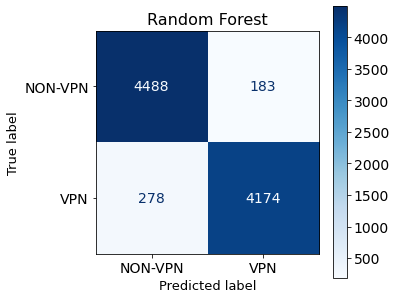

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm1 = confusion_matrix(y_true1, y_pred1)

cmp = ConfusionMatrixDisplay(cm1,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Random Forest', fontdict = {'fontsize': 16})
ax.set_xlabel("Predicted Class", fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 2: Decision Tree

In [ ]:
#-----------------DECISION TREE ALGORİTMASI------------------------

from pyspark.ml.classification import DecisionTreeClassifier

dtr = DecisionTreeClassifier(labelCol='Traffic', featuresCol='scaledFeatures', maxDepth=20,maxBins=50, seed=42)
model2 = dtr.fit(train_data)
predictions2 = model2.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='Traffic', rawPredictionCol='rawPrediction' ,metricName='areaUnderROC')

auc = evaluator.evaluate(predictions2)

print("AUC = %g" % (auc))

AUC = 0.918107


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

y_true2 = predictions2.select("Traffic").toPandas()
y_pred2 = predictions2.select("Prediction").toPandas()

target_names = ["NON-VPN","VPN"]
print(classification_report(y_true2, y_pred2,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.92      0.96      0.94      4671
         VPN       0.96      0.92      0.94      4452

    accuracy                           0.94      9123
   macro avg       0.94      0.94      0.94      9123
weighted avg       0.94      0.94      0.94      9123



In [ ]:
print ("accuracy: ",accuracy_score(y_true2, y_pred2))
print ("f1-score: ",f1_score(y_true2, y_pred2))
print ("recall: ", recall_score(y_true2, y_pred2))
print ("precision: ", precision_score(y_true2, y_pred2))

accuracy:  0.9397128137674011
f1-score:  0.9369555249885373
recall:  0.9180143755615454
precision:  0.9566947565543071


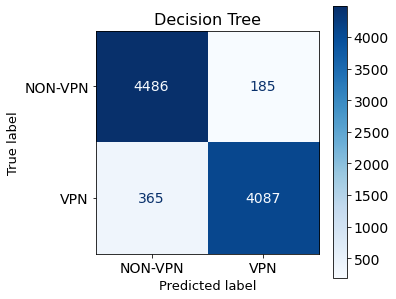

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm2 = confusion_matrix(y_true2, y_pred2)

cmp = ConfusionMatrixDisplay(cm2,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Decision Tree', fontdict = {'fontsize': 16})
ax.set_xlabel("Predicted Class", fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 3: Naive Bayes

In [ ]:
#------------------NAIVE BAYES ALGORİTMASI-----------------

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol='Traffic', featuresCol="scaledFeatures", smoothing=1.0, modelType="multinomial")
model3 = nb.fit(train_data)
predictions3 = model3.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='Traffic', rawPredictionCol='rawPrediction' ,metricName='areaUnderROC')

auc = evaluator.evaluate(predictions3)

print("AUC = %g" % (auc))

AUC = 0.569174


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

y_true3 = predictions3.select("Traffic").toPandas()
y_pred3 = predictions3.select("Prediction").toPandas()

target_names = ["NON-VPN","VPN"]
print(classification_report(y_true3, y_pred3,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.63      0.31      0.41      4671
         VPN       0.53      0.81      0.64      4452

    accuracy                           0.55      9123
   macro avg       0.58      0.56      0.53      9123
weighted avg       0.58      0.55      0.52      9123



In [ ]:
print ("accuracy: ",accuracy_score(y_true3, y_pred3))
print ("f1-score: ",f1_score(y_true3, y_pred3))
print ("recall: ", recall_score(y_true3, y_pred3))
print ("precision: ", precision_score(y_true3, y_pred3))

accuracy:  0.5538748218787679
f1-score:  0.6404593639575972
recall:  0.814240790655885
precision:  0.5278101339545719


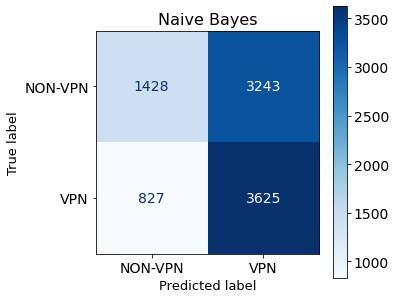

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm3 = confusion_matrix(y_true3, y_pred3)

cmp = ConfusionMatrixDisplay(cm3,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Naive Bayes', fontdict = {'fontsize': 16})
ax.set_xlabel("Predicted Class", fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 4: Logistic Regression

In [ ]:
#------------------ LOGISTIC RESGRESSION ALGORİTMASI------------------
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='Traffic', featuresCol='scaledFeatures')
model4 = lr.fit(train_data)
predictions4 = model4.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='Traffic', rawPredictionCol='rawPrediction' ,metricName='areaUnderROC')

auc = evaluator.evaluate(predictions4)

print("AUC = %g" % (auc))

AUC = 0.860468


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

y_true4 = predictions4.select("Traffic").toPandas()
y_pred4 = predictions4.select("Prediction").toPandas()

target_names = ["NON-VPN","VPN"]
print(classification_report(y_true4, y_pred4,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.80      0.82      0.81      4671
         VPN       0.80      0.78      0.79      4452

    accuracy                           0.80      9123
   macro avg       0.80      0.80      0.80      9123
weighted avg       0.80      0.80      0.80      9123



In [ ]:
print ("accuracy: ",accuracy_score(y_true4, y_pred4))
print ("f1-score: ",f1_score(y_true4, y_pred4))
print ("recall: ", recall_score(y_true4, y_pred4))
print ("precision: ", precision_score(y_true4, y_pred4))

accuracy:  0.8012715115641784
f1-score:  0.7934844515320653
recall:  0.782345013477089
precision:  0.8049456898544026


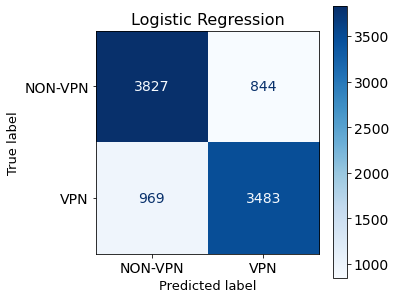

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm4 = confusion_matrix(y_true4, y_pred4)

cmp = ConfusionMatrixDisplay(cm4,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Logistic Regression', fontdict = {'fontsize': 16})
ax.set_xlabel("Predicted Class", fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 5: MLP

In [ ]:
#--------------------MULTILAYER PERCEPTRON ALGORİTMASI-------------------

layers = [65,33,2] 

from pyspark.ml.classification import MultilayerPerceptronClassifier

mpc = MultilayerPerceptronClassifier(labelCol='Traffic', featuresCol="scaledFeatures", 
                        maxIter=100, layers=layers, blockSize=128, seed=42)
model5 = mpc.fit(train_data)
predictions5 = model5.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol='Traffic', rawPredictionCol='rawPrediction' ,metricName='areaUnderROC')

auc = evaluator.evaluate(predictions5)

print("AUC = %g" % (auc))

AUC = 0.827055


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

y_true5 = predictions5.select("Traffic").toPandas()
y_pred5 = predictions5.select("Prediction").toPandas()

target_names = ["NON-VPN","VPN"]
print(classification_report(y_true5, y_pred5,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.82      0.70      0.76      4671
         VPN       0.73      0.84      0.78      4452

    accuracy                           0.77      9123
   macro avg       0.78      0.77      0.77      9123
weighted avg       0.78      0.77      0.77      9123



In [ ]:
print ("accuracy: ",accuracy_score(y_true5, y_pred5))
print ("f1-score: ",f1_score(y_true5, y_pred5))
print ("recall: ", recall_score(y_true5, y_pred5))
print ("precision: ", precision_score(y_true5, y_pred5))

accuracy:  0.7700317877891044
f1-score:  0.7815948365604831
recall:  0.8432165318957772
precision:  0.7283663174233604


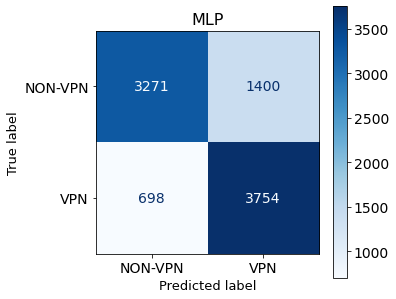

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm5 = confusion_matrix(y_true5, y_pred5)

cmp = ConfusionMatrixDisplay(cm5,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('MLP', fontdict = {'fontsize': 16})
ax.set_xlabel("Predicted Class", fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

### 6: DNN

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Traffic').collect())
ytest_array = np.asarray(test_data.select('Traffic').collect())

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,65)
xtest_array = xtest_array.reshape(-1,65)

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 65)
(9123, 65)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model6 = Sequential()

model6.add(Dense(128,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(1,activation = "sigmoid"))

model6.compile(loss="binary_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25) 

model6.fit(xtrain_array, ytrain_array, epochs=30, 
          validation_data=(xtest_array, ytest_array),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 3s 2ms/step - loss: 0.5120 - val_loss: 0.4648
Epoch 2/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.4557 - val_loss: 0.4460
Epoch 3/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.4242 - val_loss: 0.3975
Epoch 4/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.3805 - val_loss: 0.3452
Epoch 5/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.3455 - val_loss: 0.3210
Epoch 6/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.3172 - val_loss: 0.3109
Epoch 7/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.2962 - val_loss: 0.2818
Epoch 8/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.2969 - val_loss: 0.2701
Epoch 9/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.2928 - val_loss: 0.2929
Epoch 10/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.280

In [ ]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8448      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Deep Neural Network (DNN)')

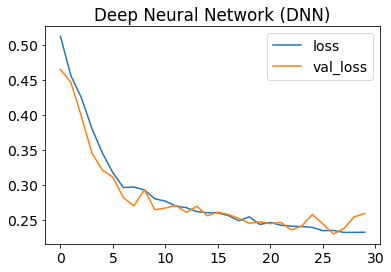

In [ ]:
kayipDf6 = pd.DataFrame(model6.history.history)
ax6 = kayipDf6.plot()
ax6.set_title("Deep Neural Network (DNN)")

In [ ]:
y_pred6 = model6.predict(xtest_array)

In [ ]:
y_pred6 = np.where(y_pred6 > 0.5, 1, 0)
y_pred6

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

target_names = ["NON-VPN","VPN"]
print(classification_report(ytest_array, y_pred6,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.91      0.90      0.91      4671
         VPN       0.90      0.91      0.90      4452

    accuracy                           0.91      9123
   macro avg       0.91      0.91      0.91      9123
weighted avg       0.91      0.91      0.91      9123



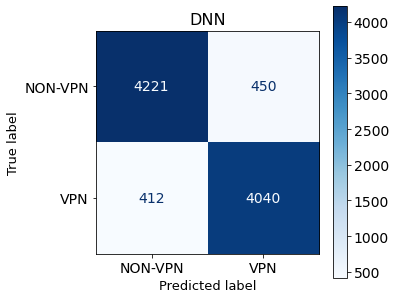

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm6 = confusion_matrix(ytest_array,y_pred6)

cmp = ConfusionMatrixDisplay(cm6,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('DNN', fontdict = {'fontsize': 16})
ax.set_xlabel('Predicted Class', fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print ("accuracy: ",accuracy_score(ytest_array, y_pred6))
print ("f1-score: ",f1_score(ytest_array, y_pred6))
print ("recall: ", recall_score(ytest_array, y_pred6))
print ("precision: ", precision_score(ytest_array, y_pred6))

accuracy:  0.9055135372136358
f1-score:  0.9036009841198838
recall:  0.9074573225516622
precision:  0.8997772828507795


In [ ]:
roc_auc_score(ytest_array, y_pred6)

0.905559104435754

### 7: LSTM

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Traffic').collect())
ytest_array = np.asarray(test_data.select('Traffic').collect())

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model7 = Sequential()

model7.add(layers.LSTM(64, activation = "relu", return_sequences = True))


model7.add(layers.LSTM(64, activation = "relu", return_sequences = False))



model7.add(Dense(1,activation = "sigmoid"))

model7.compile(loss="binary_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model7.fit(xtrain_array, ytrain_array, epochs=30, 
          validation_data=(xtest_array, ytest_array),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 7s 4ms/step - loss: 0.5492 - val_loss: 0.4820
Epoch 2/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4792 - val_loss: 0.4597
Epoch 3/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4595 - val_loss: 0.4483
Epoch 4/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4407 - val_loss: 0.4184
Epoch 5/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4199 - val_loss: 0.3954
Epoch 6/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3967 - val_loss: 0.3819
Epoch 7/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3768 - val_loss: 0.3582
Epoch 8/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3636 - val_loss: 0.3429
Epoch 9/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3490 - val_loss: 0.3409
Epoch 10/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.337

In [ ]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             33280     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Long Short-Term Memory (LSTM)')

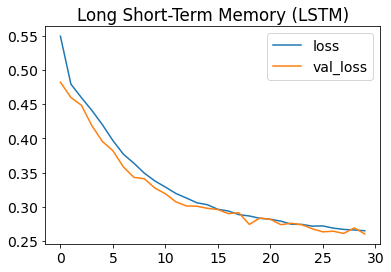

In [ ]:
kayipDf7 = pd.DataFrame(model7.history.history)
ax7 = kayipDf7.plot()
ax7.set_title("Long Short-Term Memory (LSTM)")

In [ ]:
y_pred7 = model7.predict(xtest_array)

In [ ]:
y_pred7 = np.where(y_pred7 > 0.5, 1, 0)
y_pred7

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

target_names = ["NON-VPN","VPN"]
print(classification_report(ytest_array, y_pred7,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.90      0.89      0.90      4671
         VPN       0.89      0.90      0.89      4452

    accuracy                           0.90      9123
   macro avg       0.90      0.90      0.90      9123
weighted avg       0.90      0.90      0.90      9123



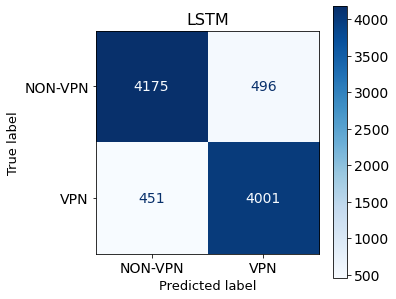

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm7 = confusion_matrix(ytest_array,y_pred7)

cmp = ConfusionMatrixDisplay(cm7,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('LSTM', fontdict = {'fontsize': 16})
ax.set_xlabel('Predicted Class', fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print ("accuracy: ",accuracy_score(ytest_array, y_pred7))
print ("f1-score: ",f1_score(ytest_array, y_pred7))
print ("recall: ", recall_score(ytest_array, y_pred7))
print ("precision: ", precision_score(ytest_array, y_pred7))

accuracy:  0.8961964266140524
f1-score:  0.8941781204603866
recall:  0.8986972147349506
precision:  0.8897042472759618


In [ ]:
roc_auc_score(ytest_array, y_pred7)

0.896255051383746

### 8: GRU

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Traffic').collect())
ytest_array = np.asarray(test_data.select('Traffic').collect())

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model9 = Sequential()

model9.add(layers.GRU(40, activation = "relu", return_sequences = True))


model9.add(layers.GRU(16, activation = "relu", return_sequences = False))


model9.add(Dense(1,activation = "sigmoid"))

model9.compile(loss="binary_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model9.fit(xtrain_array, ytrain_array, epochs=30, 
          validation_data=(xtest_array, ytest_array),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 7s 4ms/step - loss: 0.5682 - val_loss: 0.4897
Epoch 2/30
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4874 - val_loss: 0.4697
Epoch 3/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4706 - val_loss: 0.4576
Epoch 4/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4572 - val_loss: 0.4476
Epoch 5/30
1138/1138 [==============================] - 6s 5ms/step - loss: 0.4465 - val_loss: 0.4330
Epoch 6/30
1138/1138 [==============================] - 5s 5ms/step - loss: 0.4357 - val_loss: 0.4278
Epoch 7/30
1138/1138 [==============================] - 6s 5ms/step - loss: 0.4252 - val_loss: 0.4099
Epoch 8/30
1138/1138 [==============================] - 6s 5ms/step - loss: 0.4159 - val_loss: 0.4004
Epoch 9/30
1138/1138 [==============================] - 4s 3ms/step - loss: 0.4046 - val_loss: 0.3981
Epoch 10/30
1138/1138 [==============================] - 4s 3ms/step - loss: 0.396

In [ ]:
model9.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 40)             12840     
                                                                 
 gru_1 (GRU)                 (None, 16)                2784      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 15,641
Trainable params: 15,641
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Gated Recurrent Units (GRU)')

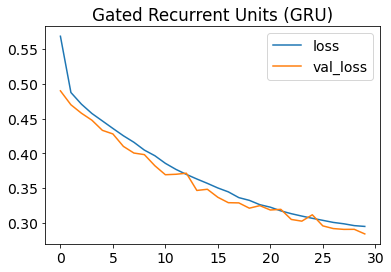

In [ ]:
kayipDf9 = pd.DataFrame(model9.history.history)
ax9 = kayipDf9.plot()
ax9.set_title("Gated Recurrent Units (GRU)")

In [ ]:
y_pred9 = model9.predict(xtest_array)

In [ ]:
y_pred9 = np.where(y_pred9 > 0.5, 1, 0)
y_pred9

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

target_names = ["NON-VPN","VPN"]
print(classification_report(ytest_array, y_pred9,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.91      0.89      0.90      4671
         VPN       0.89      0.91      0.90      4452

    accuracy                           0.90      9123
   macro avg       0.90      0.90      0.90      9123
weighted avg       0.90      0.90      0.90      9123



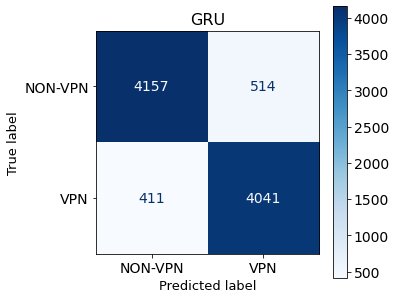

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm9 = confusion_matrix(ytest_array,y_pred9)

cmp = ConfusionMatrixDisplay(cm9,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('GRU', fontdict = {'fontsize': 16})
ax.set_xlabel('Predicted Class', fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print ("accuracy: ",accuracy_score(ytest_array, y_pred9))
print ("f1-score: ",f1_score(ytest_array, y_pred9))
print ("recall: ", recall_score(ytest_array, y_pred9))
print ("precision: ", precision_score(ytest_array, y_pred9))

accuracy:  0.8986079140633564
f1-score:  0.897302098367936
recall:  0.9076819407008087
precision:  0.8871569703622393


In [ ]:
roc_auc_score(ytest_array, y_pred9)

0.8988206320930717

### 9: 1D-CNN

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Traffic').collect())
ytest_array = np.asarray(test_data.select('Traffic').collect())

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,13,5)
xtest_array = xtest_array.reshape(-1,13,5)

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from sklearn import metrics
model8 = Sequential()
model8.add(layers.Conv1D(64,2, activation="relu", input_shape=(13,5)))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(64,2, activation="relu"))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(128,2, activation="relu"))
model8.add(layers.Flatten())
model8.add(Dense(128, activation="relu"))
model8.add(Dense(1, activation = 'sigmoid'))
model8.compile(loss = 'binary_crossentropy', optimizer = "adam" )


model8.fit(xtrain_array, ytrain_array, epochs=30,verbose=1, validation_data=(xtest_array, ytest_array))


Epoch 1/30
1138/1138 [==============================] - 7s 5ms/step - loss: 0.5240 - val_loss: 0.4910
Epoch 2/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4772 - val_loss: 0.4673
Epoch 3/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.4535 - val_loss: 0.4144
Epoch 4/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3868 - val_loss: 0.3459
Epoch 5/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3387 - val_loss: 0.3227
Epoch 6/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3222 - val_loss: 0.3126
Epoch 7/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3105 - val_loss: 0.3035
Epoch 8/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.3034 - val_loss: 0.2941
Epoch 9/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.2973 - val_loss: 0.2829
Epoch 10/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.290

In [ ]:
model8.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 12, 64)            704       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 64)             8256      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 128)            16512     
                                                                 
 flatten (Flatten)           (None, 128)              

Text(0.5, 1.0, 'Convolutional Neural Network (CNN-1D)')

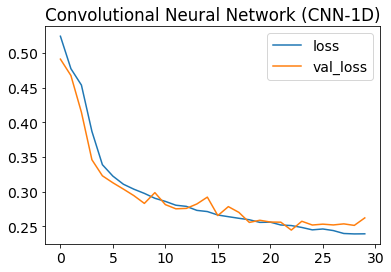

In [ ]:
kayipDf8 = pd.DataFrame(model8.history.history)
ax8 = kayipDf8.plot()
ax8.set_title("Convolutional Neural Network (CNN-1D)")

In [ ]:
y_pred8 = model8.predict(xtest_array)

In [ ]:
y_pred8 = np.where(y_pred8 > 0.5, 1, 0)
y_pred8

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

target_names = ["NON-VPN","VPN"]
print(classification_report(ytest_array, y_pred8,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.90      0.90      0.90      4671
         VPN       0.89      0.90      0.89      4452

    accuracy                           0.90      9123
   macro avg       0.90      0.90      0.90      9123
weighted avg       0.90      0.90      0.90      9123



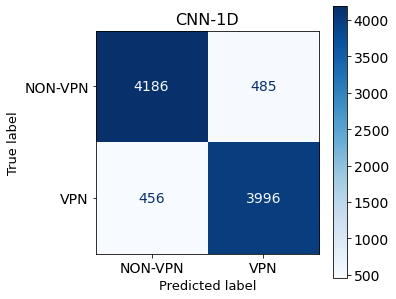

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm8 = confusion_matrix(ytest_array,y_pred8)

cmp = ConfusionMatrixDisplay(cm8,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('CNN-1D', fontdict = {'fontsize': 16})
ax.set_xlabel('Predicted Class', fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print ("accuracy: ",accuracy_score(ytest_array, y_pred8))
print ("f1-score: ",f1_score(ytest_array, y_pred8))
print ("recall: ", recall_score(ytest_array, y_pred8))
print ("precision: ", precision_score(ytest_array, y_pred8))

accuracy:  0.8968541050093171
f1-score:  0.8946602485167356
recall:  0.8975741239892183
precision:  0.8917652309752288


In [ ]:
roc_auc_score(ytest_array, y_pred8)

0.8968709840669705

### 10: CNN-LSTM

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Traffic').collect())
ytest_array = np.asarray(test_data.select('Traffic').collect())

In [ ]:
print(ytrain_array.shape)
print(ytest_array.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 1)
(9123, 1)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,13,5)
xtest_array = xtest_array.reshape(-1,13,5)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model10 = Sequential()
model10.add(layers.Conv1D(128, 2,activation="relu", input_shape=(13,5)))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.Conv1D(64, 2, activation="relu"))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.LSTM(128, activation = "relu", return_sequences = True))
model10.add(layers.LSTM(64, activation = "relu", return_sequences = False))
model10.add(layers.Flatten())
model10.add(Dense(128, activation="relu"))
model10.add(Dense(1, activation = 'sigmoid'))
model10.compile(loss = 'binary_crossentropy', optimizer = "adam" )
earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model10.fit(xtrain_array, ytrain_array, epochs=30, 
          validation_data=(xtest_array, ytest_array),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 19s 12ms/step - loss: 0.5374 - val_loss: 0.5026
Epoch 2/30
1138/1138 [==============================] - 10s 9ms/step - loss: 0.4917 - val_loss: 0.4928
Epoch 3/30
1138/1138 [==============================] - 10s 9ms/step - loss: 0.4776 - val_loss: 0.4716
Epoch 4/30
1138/1138 [==============================] - 10s 9ms/step - loss: 0.4644 - val_loss: 0.4554
Epoch 5/30
1138/1138 [==============================] - 10s 9ms/step - loss: 0.4539 - val_loss: 0.4389
Epoch 6/30
1138/1138 [==============================] - 10s 9ms/step - loss: 0.4386 - val_loss: 0.4248
Epoch 7/30
1138/1138 [==============================] - 12s 10ms/step - loss: 0.4052 - val_loss: 0.4023
Epoch 8/30
1138/1138 [==============================] - 13s 12ms/step - loss: 0.3605 - val_loss: 0.3324
Epoch 9/30
1138/1138 [==============================] - 12s 10ms/step - loss: 0.3200 - val_loss: 0.3036
Epoch 10/30
1138/1138 [==============================] - 11s 10ms/ste

In [ ]:
model10.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 12, 128)           1408      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 5, 64)             16448     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 2, 128)            98816     
                                                                 
 lstm_15 (LSTM)              (None, 64)              

Text(0.5, 1.0, 'CNN-LSTM')

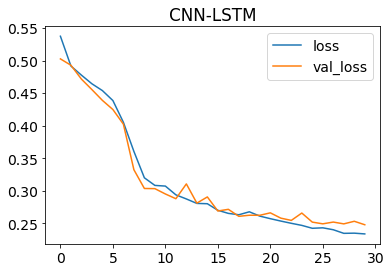

In [ ]:
kayipDf10 = pd.DataFrame(model10.history.history)
ax10 = kayipDf10.plot()
ax10.set_title("CNN-LSTM")

In [ ]:
y_pred10 = model10.predict(xtest_array)

In [ ]:
y_pred10 = np.where(y_pred10 > 0.5, 1, 0)
y_pred10

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score

target_names = ["NON-VPN","VPN"]
print(classification_report(ytest_array, y_pred10,target_names = target_names))

              precision    recall  f1-score   support

     NON-VPN       0.90      0.90      0.90      4671
         VPN       0.90      0.90      0.90      4452

    accuracy                           0.90      9123
   macro avg       0.90      0.90      0.90      9123
weighted avg       0.90      0.90      0.90      9123



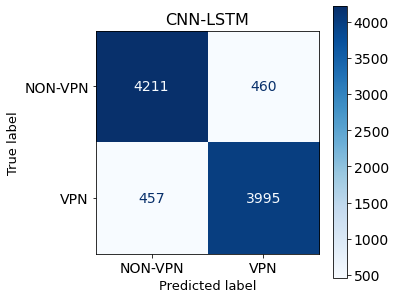

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm10 = confusion_matrix(ytest_array,y_pred10)

cmp = ConfusionMatrixDisplay(cm10,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('CNN-LSTM', fontdict = {'fontsize': 16})
ax.set_xlabel('Predicted Class', fontdict = {'fontsize': 13})
ax.set_ylabel('True Class', fontdict = {'fontsize': 13})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print ("accuracy: ",accuracy_score(ytest_array, y_pred10))
print ("f1-score: ",f1_score(ytest_array, y_pred10))
print ("recall: ", recall_score(ytest_array, y_pred10))
print ("precision: ", precision_score(ytest_array, y_pred10))

accuracy:  0.899484818590376
f1-score:  0.8970472661951275
recall:  0.8973495058400719
precision:  0.8967452300785634


In [ ]:
roc_auc_score(ytest_array, y_pred10)

0.8994347614835125

<Figure size 432x288 with 0 Axes>

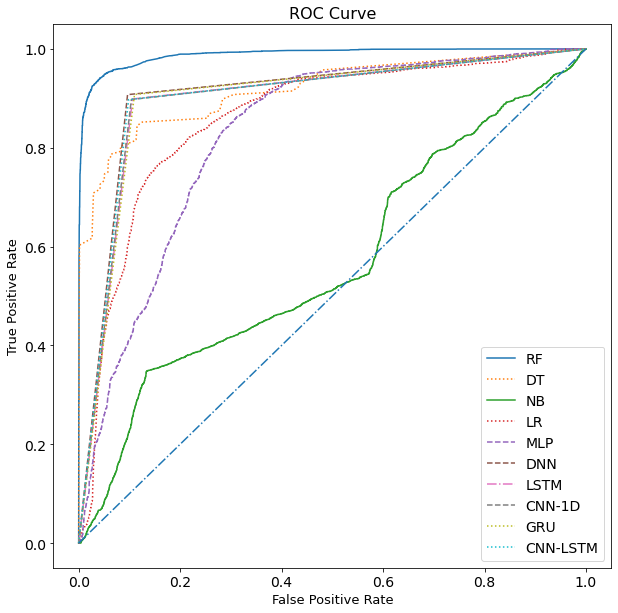

In [ ]:
from pyspark.ml.functions import vector_to_array

plt.figure(0).clf()
fig, ax, = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.xlabel("False Positive Rate", fontdict = {'fontsize': 13})
plt.ylabel("True Positive Rate",fontdict = {'fontsize': 13})
plt.title("ROC Curve",fontdict = {'fontsize': 16})

y_pred1 = prediction1.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_true1 = prediction1.select("Traffic").rdd.keys().collect()
fpr1, tpr1, _ = metrics.roc_curve(y_true1, y_pred1)
plt.plot(fpr1,tpr1,label="RF")

y_pred2 = predictions2.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_true2 = predictions2.select("Traffic").rdd.keys().collect()
fpr2, tpr2,_= metrics.roc_curve(y_true2, y_pred2)
plt.plot(fpr2,tpr2,label="DT", linestyle=':')

y_pred3 = predictions3.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_true3 = predictions3.select("Traffic").rdd.keys().collect()
fpr3, tpr3, _ = metrics.roc_curve(y_true3, y_pred3)
plt.plot(fpr3,tpr3,label="NB")

y_pred4 = predictions4.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_true4 = predictions4.select("Traffic").rdd.keys().collect()
fpr4, tpr4, _ = metrics.roc_curve(y_true4, y_pred4)
plt.plot(fpr4,tpr4,label="LR", linestyle='dotted')

y_pred5 = predictions5.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_true5 = predictions5.select("Traffic").rdd.keys().collect()
fpr5, tpr5, _ = metrics.roc_curve(y_true5, y_pred5)
plt.plot(fpr5,tpr5,label="MLP", linestyle='--')


fpr6, tpr6, _ = metrics.roc_curve(ytest_array, y_pred6)
plt.plot(fpr6,tpr6,label="DNN", linestyle='--')

fpr7, tpr7, _ = metrics.roc_curve(ytest_array, y_pred7)
plt.plot(fpr7,tpr7,label="LSTM", linestyle='dashdot')

fpr8, tpr8, _ = metrics.roc_curve(ytest_array, y_pred8)
plt.plot(fpr8,tpr8,label="CNN-1D", linestyle='--')

fpr9, tpr9, _ = metrics.roc_curve(ytest_array, y_pred9)
plt.plot(fpr9,tpr9,label="GRU", linestyle=':')

fpr10, tpr10, _ = metrics.roc_curve(ytest_array, y_pred10)
plt.plot(fpr10,tpr10,label="CNN-LSTM", linestyle='dotted')

plt.plot([0, 1], [0, 1], linestyle = '-.')


plt.legend()

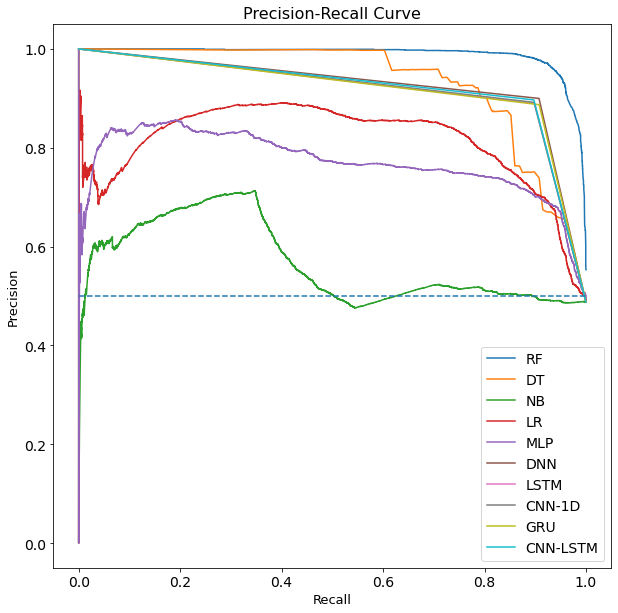

In [ ]:
from sklearn.metrics import precision_recall_curve

fig, ax, = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.xlabel("Recall", fontdict = {'fontsize': 13})
plt.ylabel("Precision",fontdict = {'fontsize': 13 })
plt.title("Precision-Recall Curve",fontdict = {'fontsize': 16})

precision1, recall1, thresholds1 = precision_recall_curve(y_true1, y_pred1)
plt.plot(recall1, precision1,label ="RF")

precision2, recall2, thresholds2 = precision_recall_curve(y_true2, y_pred2)
plt.plot(recall2, precision2,label ="DT")

precision3, recall3, thresholds3 = precision_recall_curve(y_true3, y_pred3)
plt.plot(recall3, precision3,label ="NB")

precision4, recall4, thresholds4 = precision_recall_curve(y_true4, y_pred4)
plt.plot(recall4, precision4,label ="LR")

precision5, recall5, thresholds5 = precision_recall_curve(y_true5, y_pred5)
plt.plot(recall5, precision5,label ="MLP")

precision6, recall6, thresholds6 = precision_recall_curve(ytest_array, y_pred6)
plt.plot(recall6, precision6,label ="DNN")

precision7, recall7, thresholds7 = precision_recall_curve(ytest_array, y_pred7)
plt.plot(recall7, precision7,label ="LSTM")

precision8, recall8, thresholds8 = precision_recall_curve(ytest_array, y_pred8)
plt.plot(recall8, precision8,label ="CNN-1D")

precision9, recall9, thresholds9 = precision_recall_curve(ytest_array, y_pred9)
plt.plot(recall9, precision9,label ="GRU")

precision10, recall10, thresholds10 = precision_recall_curve(ytest_array, y_pred10)
plt.plot(recall10, precision10,label ="CNN-LSTM")

plt.plot([0, 1], [0.5, 0.5], linestyle = '--')

plt.legend();